In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [76]:
# df0 = pd.read_excel("/Users/bachphamm/Documents/DA401/Homework/Data/Season 2023-2024/2023-2024.xlsx")
# df1 = pd.read_csv("/Users/bachphamm/Documents/DA401/Homework/Data/Anthropometric Data (2000-2024)/NBA_draft_combine.csv")
# df3 = pd.read_parquet("/Users/bachphamm/Documents/DA401/Homework/Data/Seasonal Data (1994-2022)/average.parq")
# df4 = pd.read_parquet("/Users/bachphamm/Documents/DA401/Homework/Data/Seasonal Data (1994-2022)/advanced.parq")

In [ ]:
# GitHub URLs for each dataset
df0_url = "https://raw.githubusercontent.com/bachphamm/da401/main/2023-2024.xlsx"
df1_url = "https://raw.githubusercontent.com/bachphamm/da401/main/NBA_draft_combine.csv"
df3_url = "https://raw.githubusercontent.com/bachphamm/da401/main/average.parq"
df4_url = "https://raw.githubusercontent.com/bachphamm/da401/main/advanced.parq"

# Load datasets from GitHub
df0 = pd.read_excel(df0_url)
df1 = pd.read_csv(df1_url)
df3 = pd.read_parquet(df3_url)
df4 = pd.read_parquet(df4_url)

**EDA**

*Data Processing*

In [77]:
# Replace the incorrect weight value for Randall Orr
df1.loc[df1['PLAYER'] == 'Orr, Randall', 'WGT'] = 193.0

# Filter the dataset to include only rows where 'YEAR' is between 2003 and 2023
df1 = df1[(df1['YEAR'] >= 2003) & (df1['YEAR'] <= 2023)]

# Change name formatting
df1['PLAYER'] = df1['PLAYER'].str.replace(r'^(.*), (.*)$', r'\2 \1', regex=True)

# Select the relevant columns for clustering and convert to numeric
df1['WGT'] = pd.to_numeric(df1['WGT'], errors='coerce')  # Explicitly converting to numeric
df1['HGT'] = pd.to_numeric(df1['HGT'], errors='coerce')
df1['WNGSPN'] = pd.to_numeric(df1['WNGSPN'], errors='coerce')
df1['LPVERT'] = pd.to_numeric(df1['LPVERT'], errors='coerce')
df1['SPRINT'] = pd.to_numeric(df1['SPRINT'], errors='coerce')

# Select relevant physical and dynamic traits 
rel_traits = ['HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']

# Drop rows with missing values
traits = df1[rel_traits].dropna()

In [121]:
df1.head()

,YEAR,PLAYER,POS,HGT,WGT,BMI,BF,WNGSPN,STNDRCH,HANDL,...,LPVERT,LANE,SHUTTLE,SPRINT,BENCH,BAR,PAN,PBHGT,PDHGT,Cluster_2
83,2023,Amari Bailey,SG,75.3,190.8,23.69,NaN,79.0,103.5,8.00,...,35.0,11.0,NaN,3.19,NaN,1.050,74.0,132.0,138.5,0
84,2023,Emoni Bates,SF,80.3,179.2,19.56,NaN,81.0,105.0,8.00,...,33.0,12.0,NaN,3.00,NaN,1.009,66.0,132.0,138.0,0
85,2023,Anthony Black,PG,77.8,210.0,24.42,NaN,79.5,102.5,8.25,...,39.0,11.0,NaN,3.00,NaN,1.023,78.4,134.5,141.5,0
86,2023,Kobe Brown,PF,78.5,252.2,28.77,NaN,84.8,106.5,8.75,...,32.0,11.0,3.0,3.00,NaN,1.080,85.3,135.5,138.5,1
87,2023,Kobe Bufkin,SG,76.3,186.8,22.59,NaN,79.8,102.5,8.00,...,36.0,12.0,NaN,3.00,NaN,1.046,74.0,131.5,138.5,0


In [78]:
# Rename "team_retcon"
df4 = df4.rename(columns={'team_retcon': 'Team'})

# Convert "season" to the correct "Year" by extracting the start year and subtracting 1
df4['Year'] = df4['season'].apply(lambda x: str(int(x.split('/')[0]) - 1))

# Drop the old "season" column if no longer needed
df4 = df4.drop(columns=['season', 'Rk', 'Unnamed: 17', 'Unnamed: 22'])

# Reorder columns to make "Year" the first column
df4 = df4[['Year'] + [col for col in df4.columns if col != 'Year']]

In [122]:
df4.head()

,Year,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,team,Team
0,1994,Christian Laettner,25,81,2770,17.7,0.580,0.043,0.543,7.3,...,3.6,2.6,6.2,0.108,0.7,0.4,1.1,2.2,MIN,MIN
1,1994,Isaiah Rider,23,75,2645,15.6,0.548,0.317,0.271,4.2,...,1.4,0.4,1.9,0.034,2.0,-2.5,-0.5,1.0,MIN,MIN
2,1994,Sean Rooks,25,80,2405,12.6,0.555,0.008,0.620,8.5,...,1.9,1.1,3.0,0.060,-1.5,-1.5,-3.0,-0.6,MIN,MIN
3,1994,Doug West,27,71,2328,11.6,0.528,0.080,0.323,3.2,...,1.2,0.6,1.8,0.038,-2.2,-1.2,-3.4,-0.8,MIN,MIN
4,1994,Winston Garland,30,73,1931,10.1,0.488,0.183,0.273,3.1,...,0.6,0.6,1.2,0.030,-2.2,-0.3,-2.6,-0.3,MIN,MIN


*Physical and Dynamic Trait Distribution*

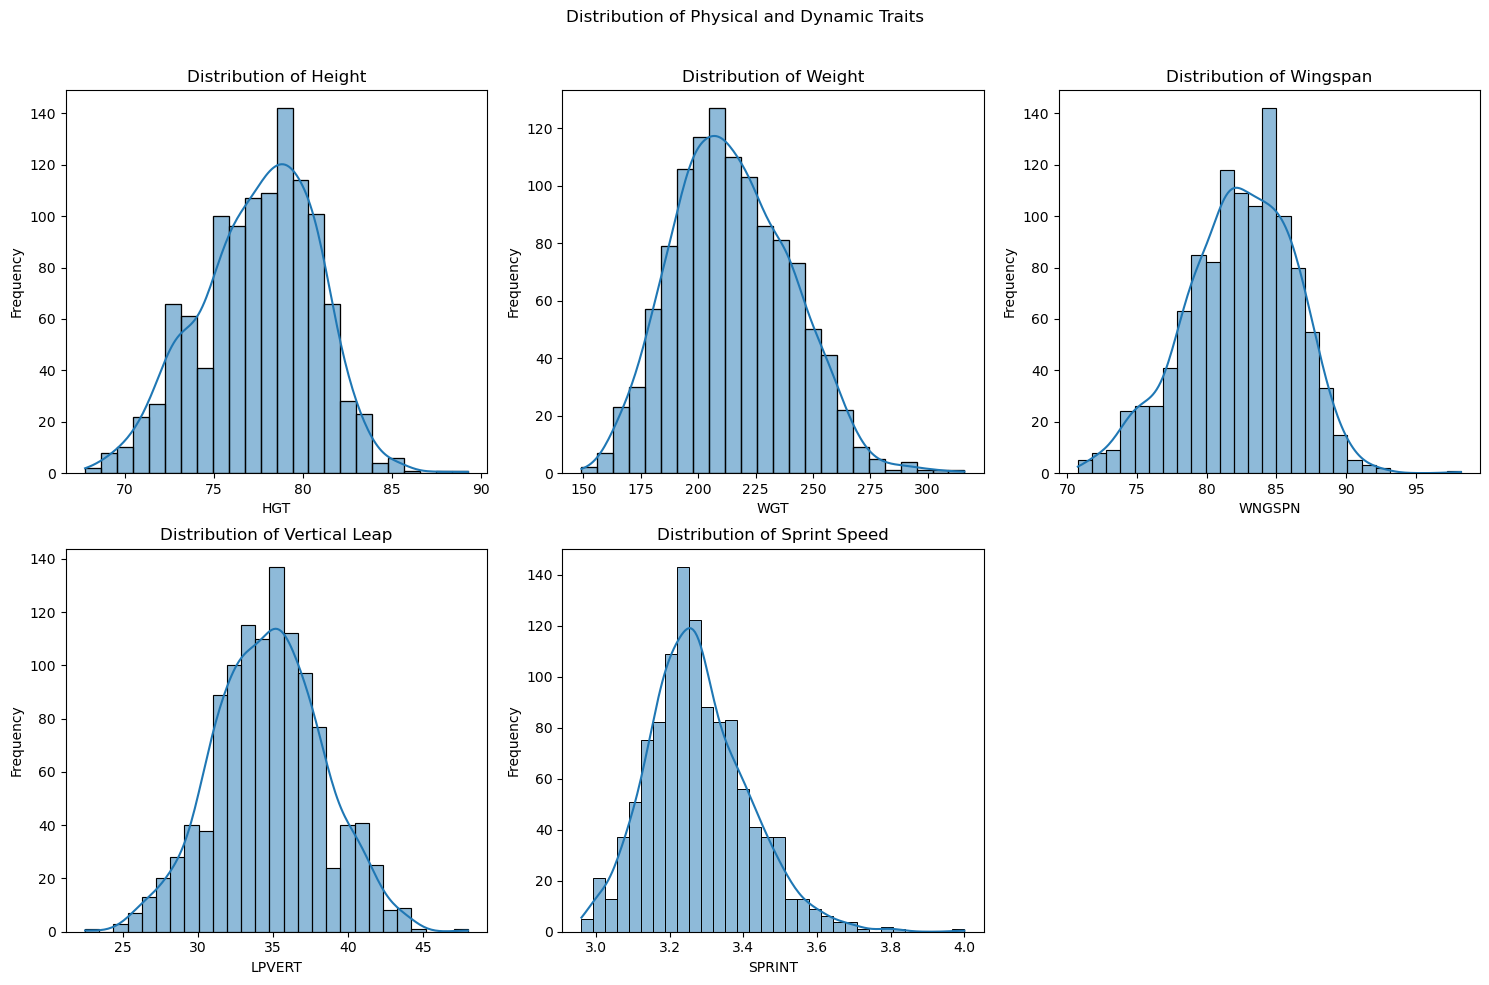

In [79]:
# Set up the figure and axes for a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution of Physical and Dynamic Traits")

# Flatten axes for easy iteration
axes = axes.ravel()

# Define custom titles for each trait
custom_titles = {
    'HGT': 'Height',
    'WGT': 'Weight',
    'WNGSPN': 'Wingspan',
    'LPVERT': 'Vertical Leap',
    'SPRINT': 'Sprint Speed'
}

# Plot each trait's distribution
for i, trait in enumerate(traits.columns):
    sns.histplot(traits[trait], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {custom_titles.get(trait, trait)}')
    axes[i].set_xlabel(trait)
    axes[i].set_ylabel('Frequency')

# Remove the last empty subplot if exists
for j in range(len(traits.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust layout to make room for the main title
plt.show()

*Standardize Physical and Dynamic Trait Data*

In [80]:
# Standardize the data to z-scores
scaler = StandardScaler()
z_traits = scaler.fit_transform(traits)

*Multicollinearity Check*

In [81]:

# Calculate VIF for each feature to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = traits.columns
vif_data['VIF'] = [variance_inflation_factor(z_traits, i) for i in range(z_traits.shape[1])]

# Display the VIF data
print(vif_data)

  Feature       VIF
0     HGT  3.914967
1     WGT  2.579100
2  WNGSPN  3.535200
3  LPVERT  1.601016
4  SPRINT  1.668561


**Analysis**

*Two-step Cluster (Log-likelihood and Schwarz's Bayesisan Information Criteria)*

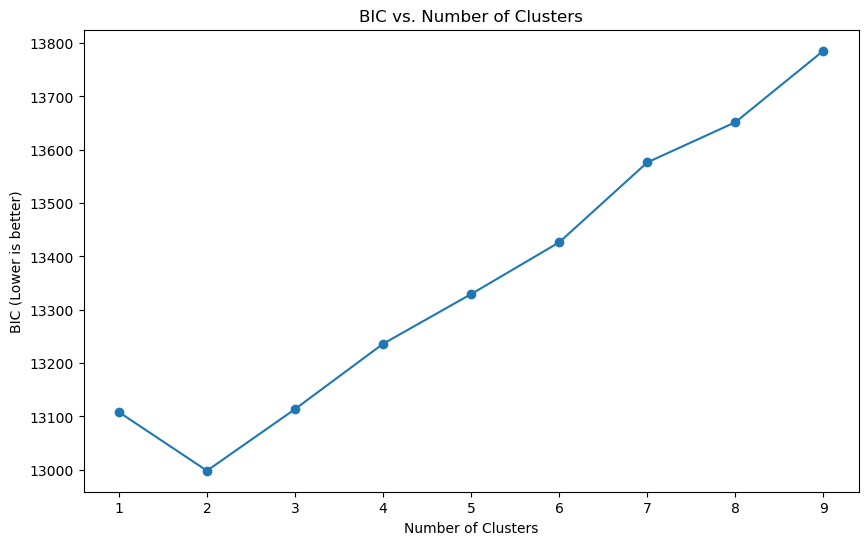

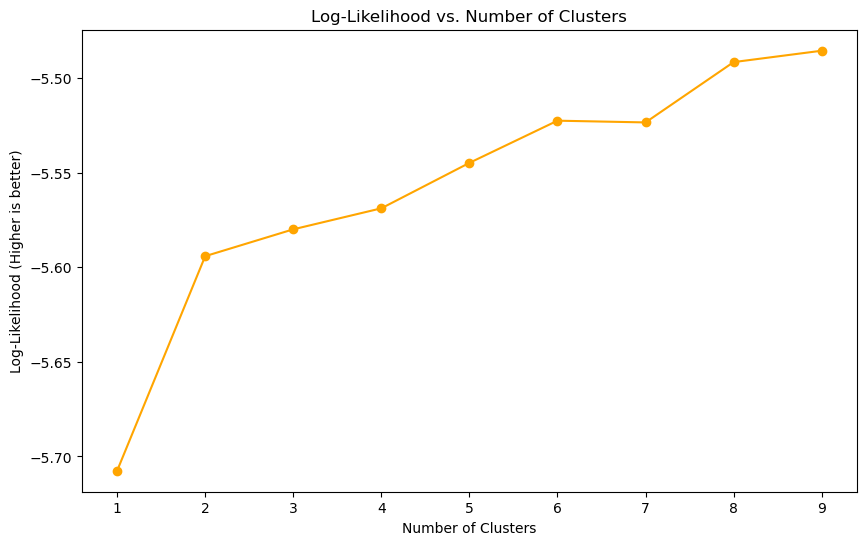

In [82]:
# Run Gaussian Mixture Model with different numbers of clusters and calculate BIC
n_clusters0 = range(1, 10)  # Try different cluster numbers
bics = []
log_likelihoods = []

for n in n_clusters0:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(z_traits)
    bics.append(gmm.bic(z_traits))  # Schwarz criterion (BIC)
    log_likelihoods.append(gmm.score(z_traits))  # Log-likelihood

# Plot BIC values to find the optimal number of clusters (Elbow method)
plt.figure(figsize=(10, 6))
plt.plot(n_clusters0, bics, marker='o')
plt.title("BIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC (Lower is better)")
plt.show()

# Plot Log-Likelihood values for reference
plt.figure(figsize=(10, 6))
plt.plot(n_clusters0, log_likelihoods, marker='o', color='orange')
plt.title("Log-Likelihood vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Log-Likelihood (Higher is better)")
plt.show()

*Clusters Validation (Elbow and Silhouette)*

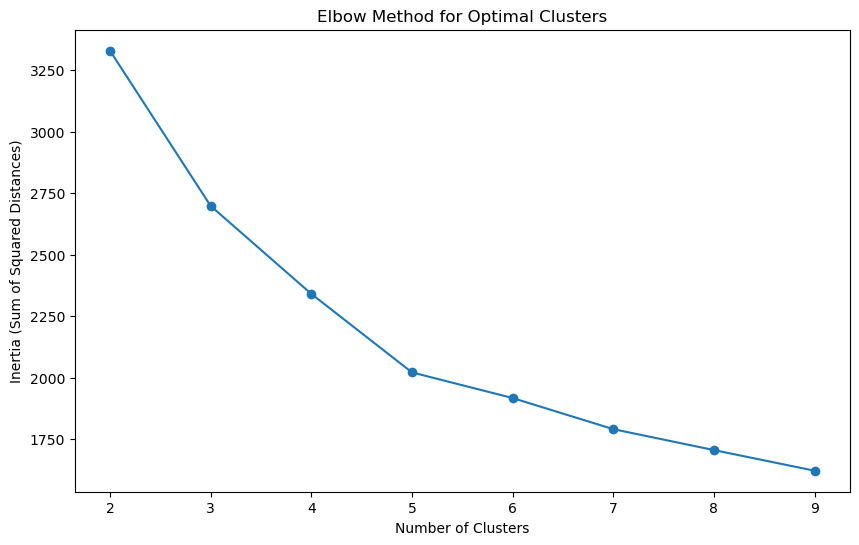

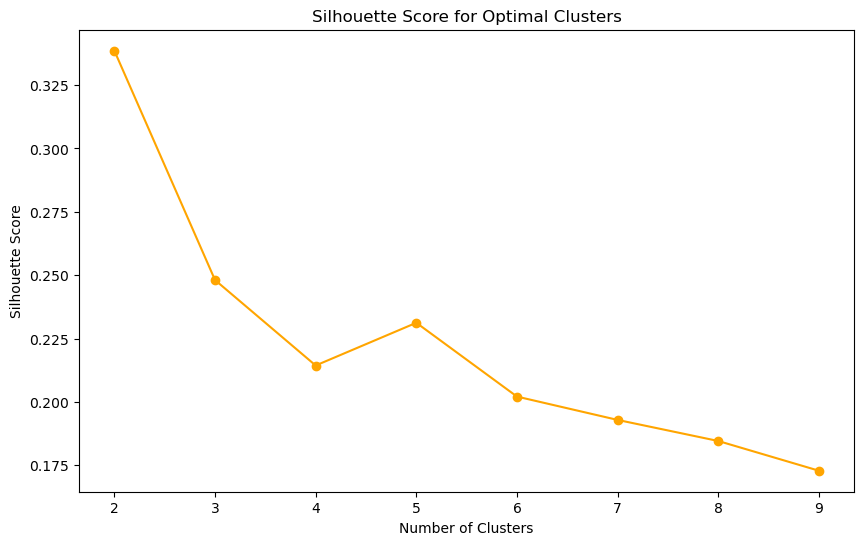

In [83]:
# Range of clusters to evaluate
n_clusters1 = range(2, 10)  # Starting from 2 clusters as 1 cluster won't be meaningful for silhouette scores

# Lists to store evaluation metrics
inertia = []  # For elbow method
silhouette_scores = []  # For silhouette score

# Calculate inertia and silhouette score for each cluster count
for n in n_clusters1:
    kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
    kmeans.fit(z_traits)
    
    # Append inertia (for elbow method)
    inertia.append(kmeans.inertia_)
    
    # Append silhouette score (only if n > 1, as silhouette score requires >1 clusters)
    silhouette_avg = silhouette_score(z_traits, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(n_clusters1, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters1, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


In [114]:
# Apply KMeans with 2 clusters
kmeans_2 = KMeans(n_clusters=2, n_init='auto', random_state=42)
kmeans_2.fit(z_traits)
traits['Cluster_2'] = kmeans_2.labels_

# Add cluster labels back to the original DataFrame
df1['Cluster_2'] = None
df1.loc[traits.index, 'Cluster_2'] = traits['Cluster_2']

# Now try calculating mean values for each cluster
print("Characteristics of 2-Cluster Solution")
print(df1.groupby('Cluster_2')[['HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']].mean())

Characteristics of 2-Cluster Solution
                 HGT         WGT     WNGSPN     LPVERT    SPRINT
Cluster_2                                                       
0          75.063024  196.859266  79.605857  36.429196  3.207535
1          79.948316  233.329078  85.176418  32.996454  3.345940


In [85]:
# Rename columns
og_names = ['YEAR', 'PLAYER', 'POS', 'HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']
new_names = ['Year', 'Player', 'Position', 'Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']

# DataFrames for each cluster, selecting only the original names and renaming them
traits_0 = df1[df1['Cluster_2'] == 0][og_names].copy()
traits_0.columns = new_names  # Apply new names to c0

traits_1 = df1[df1['Cluster_2'] == 1][og_names].copy()
traits_1.columns = new_names  # Apply new names to c1

In [120]:
traits_0.head()

,Year,Player,Position,Height,Weight,Wingspan,Vertical,Sprint
83,2023,Amari Bailey,SG,75.3,190.8,79.0,35.0,3.19
84,2023,Emoni Bates,SF,80.3,179.2,81.0,33.0,3.00
85,2023,Anthony Black,PG,77.8,210.0,79.5,39.0,3.00
87,2023,Kobe Bufkin,SG,76.3,186.8,79.8,36.0,3.00
89,2023,Sidy Cissoko,SF,77.5,223.8,81.8,36.0,3.00


*Standardize Advanced Performance Data*

In [87]:
# Define the columns to z-score 
adv_stats0 = ['OBPM', 'TS%', 'USG%', 'AST%', 'DBPM', 'DRB%', 'BLK%', 'STL%']

# Initialize the scaler and z-score the advanced stats in df4
scaler = StandardScaler()
z_df4 = df4.copy()
z_df4[adv_stats0] = scaler.fit_transform(df4[adv_stats0])

*Two-way Player Score*

In [88]:
# Calculate the two-way player score as the average of the z-scored stats for each player
z_df4['2WS'] = z_df4[adv_stats0].mean(axis=1)

In [115]:
z_df4.head(10)

,Year,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,team,Team,2WS
0,1994,Christian Laettner,25,81,2770,17.7,0.641900,0.043,0.543,7.3,...,2.6,6.2,0.108,0.242890,0.292605,1.1,2.2,MIN,MIN,0.440536
1,1994,Isaiah Rider,23,75,2645,15.6,0.339292,0.317,0.271,4.2,...,0.4,1.9,0.034,0.373897,-1.152519,-0.5,1.0,MIN,MIN,0.020077
2,1994,Sean Rooks,25,80,2405,12.6,0.405488,0.008,0.620,8.5,...,1.1,3.0,0.060,0.021186,-0.654200,-3.0,-0.6,MIN,MIN,-0.173546
3,1994,Doug West,27,71,2328,11.6,0.150162,0.080,0.323,3.2,...,0.6,1.8,0.038,-0.049356,-0.504705,-3.4,-0.8,MIN,MIN,-0.180022
4,1994,Winston Garland,30,73,1931,10.1,-0.228098,0.183,0.273,3.1,...,0.6,1.2,0.030,-0.049356,-0.056218,-2.6,-0.3,MIN,MIN,-0.142680
5,1994,Chris Smith,24,64,1073,11.2,0.339292,0.409,0.239,1.6,...,0.3,1.2,0.056,0.101806,-0.155882,-1.1,0.2,MIN,MIN,-0.074051
6,1994,Donyell Marshall,21,40,1036,12.7,-0.568533,0.251,0.288,7.7,...,0.7,-0.1,-0.005,0.041341,-0.654200,-2.8,-0.2,MIN,MIN,0.030922
7,1994,Tom Gugliotta,25,31,1018,18.4,0.282553,0.246,0.342,6.0,...,1.3,2.1,0.097,0.394052,0.790924,3.6,1.4,MIN,MIN,0.720788
8,1994,Pat Durham,27,59,852,12.2,0.273097,0.110,0.405,5.4,...,0.5,0.9,0.051,0.011109,0.342437,-1.2,0.2,MIN,MIN,0.047762
9,1994,Greg Foster,26,61,845,10.3,0.131249,0.099,0.345,9.8,...,0.6,0.5,0.029,-0.210595,-0.704032,-5.4,-0.7,MIN,MIN,-0.214514


In [89]:
# List of columns
col_list0 = ['Year', 'Player', 'Team', 'OBPM', 'TS%', 'USG%', 'AST%', 'DBPM', 'DRB%', 'BLK%', 'STL%', '2WS']

# Filter df4 to include only the specified columns
df4_filtered = z_df4[col_list0]

# Create datasets for each cluster based on players in c0 and c1
adv_0 = df4_filtered[df4_filtered["Player"].isin(traits_0["Player"])]
adv_1 = df4_filtered[df4_filtered["Player"].isin(traits_1["Player"])]

# Remove rows with missing values
z_adv_0 = adv_0.dropna()
z_adv_1 = adv_1.dropna()

In [90]:
z_adv_0

,Year,Player,Team,OBPM,TS%,USG%,AST%,DBPM,DRB%,BLK%,STL%,2WS
118,2001,Gary Trent,MIN,0.091728,0.244727,0.207314,-0.491961,-0.255545,0.321471,0.095060,-0.534593,-0.040225
134,2002,Gary Trent,MIN,0.172348,0.348749,-0.074823,-0.314246,0.043446,0.335917,-0.106722,-0.184385,0.027535
148,2003,Gary Trent,MIN,-0.049356,0.027227,0.119146,-0.544230,-0.454873,-0.039669,-0.207613,-0.884801,-0.254271
178,2005,Rashad McCants,MIN,0.041341,0.254184,0.806857,-0.481507,-0.056218,-0.660830,-0.207613,0.078271,-0.028189
187,2005,Ronald Dupree,MIN,-0.240828,-0.171359,-0.304060,-0.439692,0.192942,-0.285244,-0.812960,0.691135,-0.171258
...,...,...,...,...,...,...,...,...,...,...,...,...
12610,2022,Nassir Little,POR,0.011109,0.405488,-0.480397,-0.596499,-0.604368,-0.126342,0.095060,-0.534593,-0.228818
12615,2022,Keon Johnson,POR,-0.210595,-0.284837,1.106629,0.825219,-0.704032,-0.747503,-0.157168,0.516031,0.042968
12617,2022,Gary Payton II,POR,-0.029201,1.899616,-1.661849,-0.146985,0.790924,-0.169679,-0.661623,1.304000,0.165650
12619,2022,Skylar Mays,POR,0.383974,1.057987,0.101513,2.821897,-0.953192,-0.574156,-0.560732,-0.096833,0.272557


*Regression Analysis*

In [91]:
# For traits_0 dataset
traits_0['Weight'] = pd.to_numeric(traits_0['Weight'], errors='coerce')
traits_0['Height'] = pd.to_numeric(traits_0['Height'], errors='coerce')
traits_0['Wingspan'] = pd.to_numeric(traits_0['Wingspan'], errors='coerce')
traits_0['Vertical'] = pd.to_numeric(traits_0['Vertical'], errors='coerce')
traits_0['Sprint'] = pd.to_numeric(traits_0['Sprint'], errors='coerce')

# For traits_1 dataset
traits_1['Weight'] = pd.to_numeric(traits_1['Weight'], errors='coerce')
traits_1['Height'] = pd.to_numeric(traits_1['Height'], errors='coerce')
traits_1['Wingspan'] = pd.to_numeric(traits_1['Wingspan'], errors='coerce')
traits_1['Vertical'] = pd.to_numeric(traits_1['Vertical'], errors='coerce')
traits_1['Sprint'] = pd.to_numeric(traits_1['Sprint'], errors='coerce')

col_list1 = ['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']

# Initialize the scaler and z-score the advanced stats in df4
scaler = StandardScaler()
z_traits_0 = traits_0.copy()
z_traits_0[col_list1] = scaler.fit_transform(traits_0[col_list1])
z_traits_1 = traits_1.copy()
z_traits_1[col_list1] = scaler.fit_transform(traits_1[col_list1])

In [92]:
# adv_stats1 = ['OBPM', 'TS%', 'USG%', 'AST%', 'DBPM', 'DRB%', 'BLK%', 'STL%', '2WS']

z_adv_0 = z_adv_0.groupby('Player', as_index=False)['2WS'].mean()
z_adv_1 = z_adv_1.groupby('Player', as_index=False)['2WS'].mean()

In [123]:
z_adv_0.head()

,Player,2WS
0,A.J. Price,-0.229124
1,Aaron Brooks,-0.053160
2,Aaron Harrison,-0.485593
3,Aaron Henry,-0.588165
4,Aaron Holiday,-0.011825


In [94]:
# Merge z_adv_0 and z_traits_0 on 'Player', keeping only the players present in z_adv_0
z_reg_0 = pd.merge(z_adv_0, z_traits_0, on='Player', how='left').drop(['Year', 'Position'], axis=1, errors='ignore')
z_reg_1 = pd.merge(z_adv_1, z_traits_1, on='Player', how='left').drop(['Year', 'Position'], axis=1, errors='ignore')

In [124]:
z_reg_0.head()

,Player,2WS,Height,Weight,Wingspan,Vertical,Sprint
0,A.J. Price,-0.229124,-1.076441,-0.259772,-1.300365,-1.680406,0.120713
1,Aaron Brooks,-0.053160,-2.126413,-2.294808,-1.216054,0.950454,-0.072970
2,Aaron Harrison,-0.485593,0.603513,0.789743,0.217234,-0.597111,0.604920
3,Aaron Henry,-0.588165,0.603513,0.815341,1.060344,-0.442355,-1.331907
4,Aaron Holiday,-0.011825,-1.391433,-0.630942,-0.035700,-1.061380,0.604920


In [126]:
# Define the dependent and independent variables
y = z_reg_0['2WS']  # Two-way score as the target variable
X = z_reg_0[['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']]  # Physical traits as predictors

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Run the multiple regression
model = sm.OLS(y, X).fit()
results = model.summary()

# Display the regression results
print(results)

                            OLS Regression Results                            
Dep. Variable:                    2WS   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.386
Date:                Wed, 13 Nov 2024   Prob (F-statistic):              0.229
Time:                        07:13:03   Log-Likelihood:                -153.55
No. Observations:                 357   AIC:                             319.1
Df Residuals:                     351   BIC:                             342.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1377      0.020     -6.816      0.0

In [127]:
# Define the dependent and independent variables
y = z_reg_1['2WS']  # Two-way score as the target variable
X = z_reg_1[['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']]  # Physical traits as predictors

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Run the multiple regression
model = sm.OLS(y, X).fit()
results = model.summary()

# Display the regression results
print(results)

                            OLS Regression Results                            
Dep. Variable:                    2WS   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     10.81
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.40e-09
Time:                        07:13:17   Log-Likelihood:                -125.92
No. Observations:                 308   AIC:                             263.8
Df Residuals:                     302   BIC:                             286.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0275      0.021     -1.299      0.1